<a href="https://colab.research.google.com/github/mgfernan/gsl_uab/blob/main/p1_fundamentals_trilateration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOCALIZATION SYSTEMS – Fundamentals and principles of operation (Practice 1)

In this practice, we will focus on the **Time-of-Arrival (TOA)** fundamentals and we will analyze how to estimate the position in presence of noise by means of an **iterative algorithm**. For this purpose, we will use Jupyter Notebook, that is based on Python, a popular high-level programming language.

In [3]:
# Add some required libraries
import math
import numpy as np
from typing import List, Tuple

import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed
from IPython.display import display

Let's define several methods that will be used later in the practice

In [4]:
# ------------------------------------------------------------------------------

def generate_noise_sample(signal:float, snr_dB:float) -> float:

  # sigma2--square of sigma, here we use: SNR_dB = 10log(d^2/sigma^2)
  sigma2 = signal**2 / math.pow(10, snr_dB / 10)
  
  # We assume additive gaussian noise
  noise = np.random.normal() * math.sqrt(sigma2)

  return noise

# ------------------------------------------------------------------------------

def plot_trilateration(nodes, x, y, activate_noise=False, snr_db=None):

    figure, axes = plt.subplots() 

    circles = []
    ranges = []

    for node in nodes:
      # Compute the distance between the node and the receiver
      radius_m = math.sqrt((node[0]-x)**2 + (node[1]-y)**2)

      # Add noise if set
      if activate_noise:
        radius_m += generate_noise_sample(radius_m, snr_db)

      ranges.append(radius_m)

      axes.text(node[0] + 0.5, node[1] + 0.5, f'{radius_m:.2f} m')

      circle = plt.Circle(node, radius=radius_m, fill=False) 
      circles.append(circle)

    for circle in circles:
      axes.add_artist(circle)

    axes.axis([-10, 20, -10, 20])
    axes.set_aspect("equal")
    axes.plot(node_x_values, node_y_values, 'D', c='red', markersize=10)
    axes.plot(x, y, 'p', c='blue', markersize=10)

    plt.title( 'Trilateration principle (without noise)' ) 
    plt.show()

    return ranges

# ------------------------------------------------------------------------------

def compute_range(from_position:List[float], to_position:List[float]) -> float:

  return np.linalg.norm(np.subtract(to_position, from_position))

# ------------------------------------------------------------------------------

def compute_gradient(nodes:List[List[float]], ranges:List[float], rx_position:List[float]) -> List[float]:

  n_nodes = len(nodes)

  gradient = [0.0, 0.0]

  # Compute the vector differences between the given position and the nodes
  pos_diff_to_nodes = np.subtract(rx_position, nodes)

  # Compute the norm of each vector difference (i.e. computed ranges)
  range_aprioris = np.linalg.norm(pos_diff_to_nodes, axis=1)

  # Compute the range differences betweem the incoming (observed) and computed
  # This amount is also called pre-fit residuals
  range_differences = ranges - range_aprioris

  # Compute the partials as division of each component by the range to each node
  partials = pos_diff_to_nodes / range_aprioris.reshape(n_nodes, 1)

  # Compute the gradient components 
  gradient_components = range_differences.reshape(n_nodes, 1) * partials
  gradient_x = gradient_components[:, 0]
  gradient_y = gradient_components[:, 1]

  return -2.0 * np.array([sum(gradient_x), sum(gradient_y)])

# ------------------------------------------------------------------------------

def steepest_descent(nodes,
                     ranges,
                     apriori:Tuple[float, float] = (0.0, 0.0),
                     step:float= 0.1, 
                     num_iterations:int = 30) -> List[Tuple[float, float]]:

    estimations = []

    x = np.array(apriori)

    for i in range(num_iterations):

      gradient = compute_gradient(nodes, ranges, x)

      x = np.subtract(x, step * gradient)

      estimations.append(x)

    return np.array(estimations)

# ------------------------------------------------------------------------------

## Scenario definition

First, we will define the coordinates for the nodes that will be used for the computation of the user location by means of the TOA technique. 

In [5]:
# Node coordinates (we create a Numpy Array to take advantage of the cool indexing features)

nodes = np.array([
         [0, 0],
         [0, 10],
         [10, 0]
])

# Number of nodes
n_nodes = len(nodes)

`nodes` can also be considered a matrix that contains the coordinates of all the nodes; as we will see later, this matrix will be very useful in order to obtain the coordinates for each node by means of an iterative loop (like `for`).

**Exercise 1**

**Examine the how the matrix `nodes` has been built in order to understand how the coordinates of the nodes are stored (rows and columns). Then, copy and complete the following code in order to plot the coordinates in a figure.**



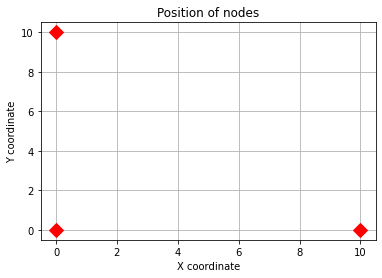

In [7]:
node_x_values = nodes[:,0]
node_y_values = nodes[:,1]

plt.title('Position of nodes')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid()
plt.plot(<put_variable_here>, <put_variable_here>, 'D', c='red', markersize=10)


The plot function plot expects, respectively, the abscissas and ordinates of the node coordinates in the first two parameters. The third parameter is used to define the style of the dots (`D` indicates diamonds).

## Trilateration principle

For the first part of the practice, we will assume a **noise-free scenario**. 

If we have three `nodes` and the corresponding distances (Time-of-arrival) to our receiver, we can compute our position based on trilaterating the 3 circles defined by this distances and the center of the circunference defined by each node. You can practice with the following widget for different receiver positions (move the X and Y sliders). 

**Note**: For now, leave `snr_db` to 0 (this slider controls the noise of the measurements and will be used later)

In [8]:
widget = interactive(plot_trilateration, x=4, y=4, activate_noise=False, snr_db=(1,30), nodes=fixed(nodes))
display(widget)

interactive(children=(IntSlider(value=4, description='x', max=12, min=-4), IntSlider(value=4, description='y',…

In [9]:
# Retrieve the range values from the interactive widget
ranges = widget.result
ranges

[5.797857768754496, 5.271403233038706, 6.050650959484662]

In [10]:
# Retrieve the true position from the interactive widget
input_values = {c.description:c.value for c in widget.children if hasattr(c, 'description') and c.description in 'xy'}
true_position = [input_values['x'], input_values['y']]
true_position

[4, 4]

**Exercise 3**

**Given a known set of coordinates for the user terminal, compute all the ranges to each node by means of the Euclidian distance with respect to the coordinates of the nodes. Verify that the ranges are consistent with the plot above. Compute the Time of arrival (TOA) for these ranges.**

Next, we will analyze the scenario in presence of noise. Go back to the interactive plot above and play with the `snr_db` slider. The larger the value, the larger the noise and the uncertainty in the position of our receiver will also increase. 

The 3 circles do not intersect anymore!

**Exercise 4**

**Analyze this noise function and describe it. Which kind of noise is added?**

Tip: in Python try to use the `help(<function>)` command to get the description 
of a particular method or function





## Finding receiver position with noisy measurements

As mentioned before the circles won’t intersect anymore if the measurements are affected by noise. Therefore, we will analyze how to estimate the position from the measured data in these scenarios, in order to obtain a more accurate position. In our case, we will choose the NLS (Non- Linear Least Square) criterion since the function of the position `u` is non-linear. This criterion minimizes the square error, however do not expect this estimation will have some noise and, depending on the geometry of the scenario, it may converge to wrong positions: for instance in the case if 2 circles intersect in 2 positions and the third is between them.

In this practice, the solution will be estimated by means of an iterative algorithm called **Steepest descent**, as we will analyze next. The Non-Linear Least Square Steepest Descent algorithm is encapsulated in the function `steepest_descent` in the code above.

In [ ]:

# Number of iterations
num_iterations = 30;

# Initial estimation of the position (initial guess also known as apriori)
apriori = (5, 2)

# Mu step
mu_step = 0.1

estimations = steepest_descent(nodes, ranges, apriori, step=mu_step, num_iterations=num_iterations)
final_estimation = estimations[-1]

The following cell plots the final result (the node positions, the true position as specified above as well as the estimated position with the Steepest Descent technique

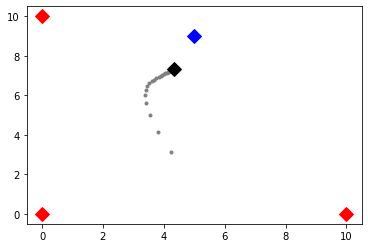

In [ ]:
# All solutions estimated by the SD algorithm
plt.plot(estimations[:, 0], estimations[:, 1], '.', color='grey')

# Last solution estimated by the SD algorithm
plt.plot(final_estimation[0], final_estimation[1], 'D', color='black', markersize=10)

# True position
plt.plot(true_position[0], true_position[1], 'D', color='blue', markersize=10)

# Nodes
plt.plot(node_x_values, node_y_values, 'D', c='red', markersize=10)

<strong>
Exercise 5

Set a *high* SNR value (`snr_db`), between 20dB and 30dB. As you know, SNR stands for Signal-to-Noise Ratio, therefore, what do you think a *high SNR ratio* mean? Run the cells and analyze the results obtained in function of the different parameters:

- the initial estimate of the position
- the number of iterations
- the step size of the algorithm

How each of these parameters affect the final estimate obtained? Justify the answers.
</strong>

<strong>
Exercise 6

Perform the same analysis of the previous exercise but using now a *lower* SNR (below 10dB). Are the intersection between the circles more defined than the previous exercise? How the noise level on the measurements affect the final result? Which parameters need to be changed in order to compensate this higher noise level? Justify the answers.
</strong>